# 中证500ETF期权策略分析

本笔记本用于分析我们的期权策略：每月初卖出中证500ETF平值看涨期权，到期前7天展期。我们将分析这个策略在一年内的表现，包括收益率、风险指标和交易统计。

In [7]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sys
import os
from dotenv import load_dotenv

# 加在项目中的.env配置 tushare的token之类的配置文件都可以放在里面
load_dotenv()

# 设置绘图风格
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# 添加项目根目录到路径
sys.path.append('..')

# 导入自定义模块 回测模块的engin 和 数据模块的data_fetcher
from backtest.engine import run_backtest
from data.data_fetcher import DataFetcher

import matplotlib.font_manager as fm

# 获取所有可用字体
# fonts = fm.findSystemFonts()
# for font in fonts:
#     print(fm.FontProperties(fname=font).get_name())

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False






## 1. 数据准备

首先，我们需要获取中证500ETF和相关期权的数据。如果数据已经存在，我们将直接加载；否则，我们将从Tushare获取数据。

In [8]:
# 定义标的种类和日期范围
underlying = 'CSI500ETF'  # 标的种类，这里暂定中证500etf
start_date = '20240101'
end_date = '20241231'

# 创建标的文件夹
underlying_folder = f'../data/{underlying}'
if not os.path.exists(underlying_folder):
    os.makedirs(underlying_folder)

# 生成包含日期的文件名
etf_data_file = f'{underlying_folder}/{start_date}_{end_date}_stock_data.csv'
option_data_file = f'{underlying_folder}/{start_date}_{end_date}_option_data.csv'

if not (os.path.exists(etf_data_file) and os.path.exists(option_data_file)):
    token = os.environ.get('TUSHARE_TOKEN')
    if token is None:
        token = input('请输入Tushare API token: ')

    fetcher = DataFetcher(token=token)

    print(f"正在获取{start_date}至{end_date} {underlying}的数据...")
    etf_data, option_data = fetcher.prepare_backtest_data(start_date, end_date)
    
    # 保存数据
    fetcher.save_data(etf_data, option_data, etf_file=etf_data_file, option_file=option_data_file)
else:
    print("数据文件已存在，将直接加载数据")

数据文件已存在，将直接加载数据


## 2. 查看数据

让我们先看看ETF和期权数据的基本情况。

In [9]:
# 加载ETF数据
etf_df = pd.read_csv(etf_data_file)
etf_df['trade_date'] = pd.to_datetime(etf_df['trade_date'])

# 显示ETF数据基本信息
print("ETF数据基本信息：")
print(f"数据时间范围：{etf_df['trade_date'].min()} 至 {etf_df['trade_date'].max()}")
print(f"交易日数量：{len(etf_df)}")
print("\n前5行数据：")
etf_df.head()

ETF数据基本信息：
数据时间范围：2024-01-02 00:00:00 至 2024-12-31 00:00:00
交易日数量：242

前5行数据：


,ts_code,trade_date,open,high,low,close,vol,amount
0,510500.SH,2024-01-02,5.524,5.530,5.492,5.497,3092572.47,1705665.321
1,510500.SH,2024-01-03,5.490,5.517,5.461,5.490,2255497.47,1238302.777
2,510500.SH,2024-01-04,5.491,5.495,5.417,5.446,2747555.34,1495540.700
3,510500.SH,2024-01-05,5.438,5.463,5.356,5.376,2031987.30,1099041.995
4,510500.SH,2024-01-08,5.361,5.364,5.248,5.250,2922712.27,1547033.096


In [10]:
# 加载期权数据
option_df = pd.read_csv(option_data_file)
option_df['trade_date'] = pd.to_datetime(option_df['trade_date'])
option_df['expire_date'] = pd.to_datetime(option_df['expire_date'])

# 显示期权数据基本信息
print("期权数据基本信息：")
print(f"期权合约数量：{option_df['ts_code'].nunique()}")
print(f"看涨期权数量：{option_df[option_df['call_put'] == 'C']['ts_code'].nunique()}")
print(f"看跌期权数量：{option_df[option_df['call_put'] == 'P']['ts_code'].nunique()}")
print("\n前5行数据：")
option_df.head()

期权数据基本信息：
期权合约数量：114
看涨期权数量：114
看跌期权数量：0

前5行数据：


,ts_code,name,call_put,exercise_price,list_date,delist_date,trade_date,exchange,pre_settle,pre_close,...,high,low,close,settle,vol,amount,oi,expire_date,days_to_expire,price_diff
0,10006312.SH,南方中证500ETF期权2401认购5.50,C,5.500,20231123,20240124,2024-01-02,SSE,0.0967,0.0967,...,0.1031,0.0710,0.0710,0.0710,70529.0,6454.9149,51832.0,2024-01-24,22,0.003
1,10006542.SH,南方中证500ETF期权2402认购5.50,C,5.500,20231228,20240228,2024-01-02,SSE,0.1384,0.1384,...,0.1406,0.1123,0.1123,0.1123,3229.0,427.4888,3256.0,2024-02-28,57,0.003
2,10005803.SH,南方中证500ETF期权2403认购5.50,C,5.500,20230727,20240327,2024-01-02,SSE,0.1629,0.1629,...,0.1668,0.1424,0.1425,0.1425,2387.0,375.8197,12416.0,2024-03-27,85,0.003
3,10006207.SH,南方中证500ETF期权2406认购5.413,C,5.413,20231026,20240626,2024-01-02,SSE,0.2040,0.2040,...,0.2205,0.1992,0.1992,0.1992,1018.0,217.8220,17352.0,2024-06-26,176,0.084
4,10006312.SH,南方中证500ETF期权2401认购5.50,C,5.500,20231123,20240124,2024-01-03,SSE,0.0710,0.0710,...,0.0851,0.0588,0.0683,0.0683,87542.0,6276.6666,54239.0,2024-01-24,21,0.010


## 3. 可视化ETF价格走势

让我们绘制中证500ETF在回测期间的价格走势图。

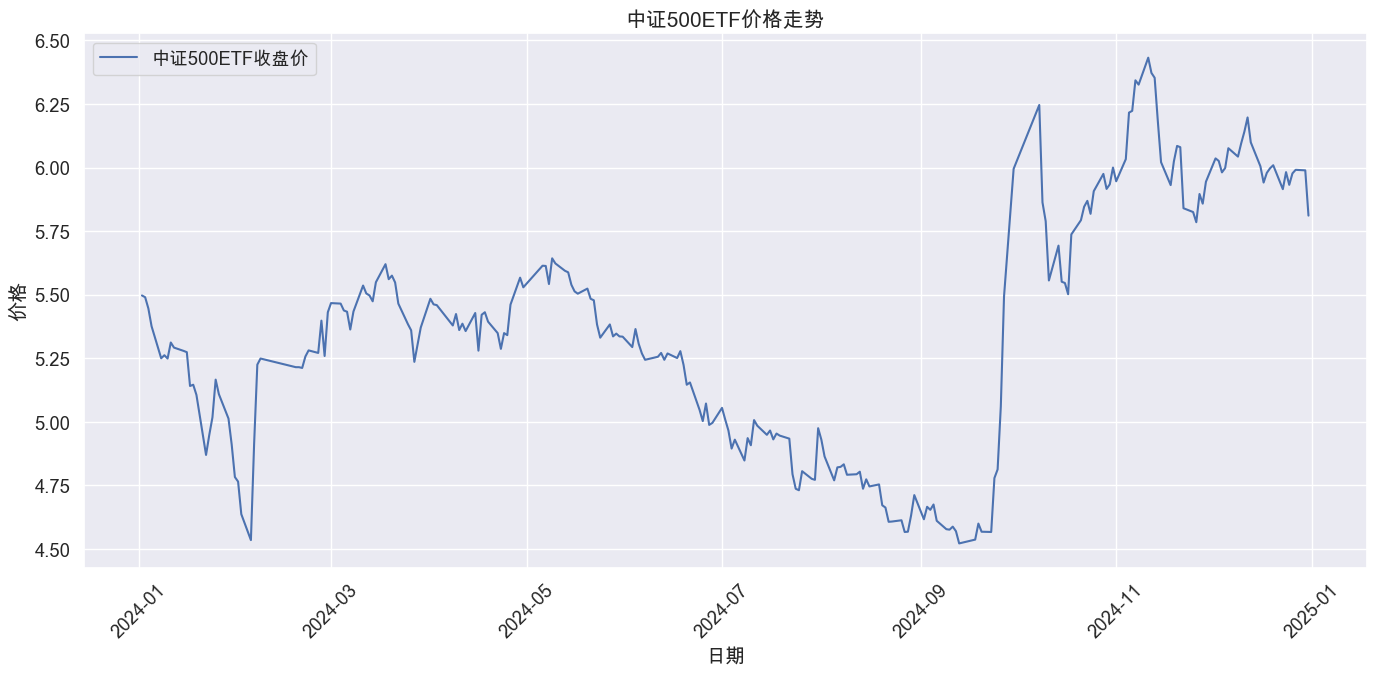

In [11]:
plt.figure(figsize=(14, 7))

# 绘制ETF收盘价走势
plt.plot(etf_df['trade_date'], etf_df['close'], label='中证500ETF收盘价')

# 添加标题和标签
plt.title('中证500ETF价格走势', fontsize=15)
plt.xlabel('日期')
plt.ylabel('价格')
plt.grid(True)
plt.legend()

# 优化x轴日期显示
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

## 4. 运行策略回测

现在，我们将运行我们的期权策略回测，并分析结果。

In [12]:
# 运行回测
results = run_backtest(
    etf_data_file=etf_data_file,
    option_data_file=option_data_file,
    cash=100000.0,  # 初始资金10万
    commission=0.0003,  # 佣金率0.03%
    days_before_expiry=7,  # 到期前7天展期
    printlog=True  # 打印日志
)

2024-12-26, 卖出平值看涨期权: 10007972.SH, 行权价: 6.0, 到期日: 2024-10-23 00:00:00


TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'datetime.date'

## 5. 分析回测结果

让我们分析回测结果，包括收益率、交易统计等。

In [ ]:
if results:
    # 基本回测结果
    print(f"初始资金: {results['initial_cash']:.2f}元")
    print(f"最终资金: {results['final_cash']:.2f}元")
    print(f"总收益率: {results['returns']:.2f}%")
    print(f"总交易次数: {len(results['trades'])}次")
    
    # 如果有交易记录，计算更多统计数据
    if results['trades']:
        trades_df = pd.DataFrame(results['trades'])
        
        # 计算平均持仓天数
        avg_days_held = trades_df['days_held'].mean()
        print(f"平均持仓天数: {avg_days_held:.2f}天")
        
        # 计算平均每笔交易收益
        avg_profit = trades_df['profit_loss'].mean()
        print(f"平均每笔交易收益: {avg_profit:.2f}元")
        
        # 计算胜率
        win_rate = (trades_df['profit_loss'] > 0).mean() * 100
        print(f"胜率: {win_rate:.2f}%")
        
        # 计算盈亏比
        profit_trades = trades_df[trades_df['profit_loss'] > 0]
        loss_trades = trades_df[trades_df['profit_loss'] < 0]
        
        if not loss_trades.empty and not profit_trades.empty:
            avg_profit = profit_trades['profit_loss'].mean()
            avg_loss = abs(loss_trades['profit_loss'].mean())
            profit_loss_ratio = avg_profit / avg_loss if avg_loss != 0 else float('inf')
            print(f"盈亏比: {profit_loss_ratio:.2f}")
else:
    print("回测失败，未能获取结果")

## 6. 可视化交易结果

让我们绘制交易结果的可视化图表。